In [1]:
import matplotlib.pyplot as plt

from scripts import tabular_baselines

import seaborn as sns
import numpy as np

from datasets import load_openml_list, valid_dids_classification, test_dids_classification, open_cc_dids
from scripts.tabular_baselines import *
from scripts.tabular_evaluation import evaluate
from scripts.tabular_metrics import calculate_score, make_ranks_and_wins_table, make_metric_matrix
from scripts import tabular_metrics
from scripts.transformer_prediction_interface import TabPFNClassifier

In [2]:
from notebook_utils import *

In [3]:
%load_ext autoreload

%autoreload 2

# Datasets

In [4]:
from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids, test_dids_classification

cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(open_cc_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)


Number of datasets: 30


# Setting params

In [6]:
import os
eval_positions = [1000]
max_features = 100
bptt = 2000
base_path = os.path.join('.')
overwrite = False
max_times = [0.5, 1, 15, 30, 60, 60*5, 60*15, 60*60]
#max_times = [1, 15, 30, 60]
metric_used = tabular_metrics.auc_metric
methods = ['transformer', 'logistic', 'catboost', 'xgb','autogluon']
task_type = 'multiclass'

In [7]:
# clf_dict= {'gp': gp_metric
#                 , 'knn': knn_metric
#                 , 'catboost': catboost_metric
#                 , 'xgb': xgb_metric
#            , 'transformer': transformer_metric
#                 , 'logistic': logistic_metric
#            , 'autosklearn': autosklearn_metric
#              , 'autosklearn2': autosklearn2_metric
#             , 'autogluon': autogluon_metric}

In [62]:
from scripts.distill_mlp import DistilledTabPFNMLP
from tabpfn.transformer_make_model import PermutationsMeta, ForwardMLPModel
from functools import partial
from scripts.tabular_baselines import knn_metric, catboost_metric, transformer_metric, logistic_metric, xgb_metric

device = "cuda"

model_string = "defaults_k_aggregate_2_batch_128_onehot_classes_multiclass_02_10_2023_23_55_16"
tabpfn_mine =  TabPFNClassifier(device=device, model_string=model_string, epoch=82, N_ensemble_configurations=32)
distilled_tabpfn = DistilledTabPFNMLP(n_epochs=1000, device="cuda", hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, )
mother_model_string = "models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_65.cpkt"
forward_mlp = PermutationsMeta(ForwardMLPModel(path=mother_model_string))
clf_dict= {#'gp': gp_metric
    'knn': knn_metric,
                 #, 'catboost': catboost_metric
                 'xgb': xgb_metric,
            #, 'transformer': transformer_metric
           'logistic': logistic_metric,
              # 'transformer_mine': partial(transformer_metric, classifier=tabpfn_mine),
              #  'distill_tabpfn':  partial(transformer_metric, classifier=distilled_tabpfn),
              #  'mother_net': partial(transformer_metric, classifier=forward_mlp)
                                            }
#            , 'autosklearn': autosklearn_metric
#              , 'autosklearn2': autosklearn2_metric
             #, 'autogluon': autogluon_metric}

# Baseline Evaluation
This section runs baselines and saves results locally.

In [63]:
!mkdir -p {base_path}/results
!mkdir -p {base_path}/results/tabular/
!mkdir -p {base_path}/results/tabular/multiclass/

In [64]:
clf_dict

{'knn': <function scripts.tabular_baselines.knn_metric(x, y, test_x, test_y, cat_features, metric_used, max_time=300, no_tune=None)>,
 'xgb': <function scripts.tabular_baselines.xgb_metric(x, y, test_x, test_y, cat_features, metric_used, max_time=300, no_tune=None, gpu_id=None)>,
 'logistic': <function scripts.tabular_baselines.logistic_metric(x, y, test_x, test_y, cat_features, metric_used, max_time=300, no_tune=None)>}

In [65]:
# transformers don't have max times
max_times = [1, 15, 30, 60]

In [66]:
cc_test_datasets_multiclass_df['isNumeric'] = (cc_test_datasets_multiclass_df.NumberOfSymbolicFeatures == 1) & (cc_test_datasets_multiclass_df.NumberOfInstancesWithMissingValues == 0)
name_indexed_dataset = cc_test_datasets_multiclass_df.set_index("name")

numeric_test_datasets = [ds for ds in cc_test_datasets_multiclass if name_indexed_dataset.loc[ds[0]].isNumeric]
len(numeric_test_datasets)

18

In [ ]:
from tabpfn.scripts.tabular_evaluation import eval_on_datasets
results = [
    eval_on_datasets('multiclass', model, model_name, numeric_test_datasets, eval_positions=eval_positions, max_time=max_time, metric_used=metric_used, split_number=split_number,
                     bptt=bptt, base_path=base_path, device=device)
    for model_name, model in clf_dict.items()
    for max_time in max_times
    for split_number in [1, 2, 3, 4, 5]
]

Loaded saved result for ./results/tabular/multiclass/results_knn_time_1_roc_auc_balance-scale_312_624_1.npy
Loaded saved result for ./results/tabular/multiclass/results_knn_time_1_roc_auc_mfeat-fourier_1000_2000_1.npy
Loaded saved result for ./results/tabular/multiclass/results_knn_time_1_roc_auc_mfeat-karhunen_1000_2000_1.npy
Loaded saved result for ./results/tabular/multiclass/results_knn_time_1_roc_auc_mfeat-morphological_1000_2000_1.npy
Loaded saved result for ./results/tabular/multiclass/results_knn_time_1_roc_auc_mfeat-zernike_1000_2000_1.npy
Loaded saved result for ./results/tabular/multiclass/results_knn_time_1_roc_auc_diabetes_384_768_1.npy
Loaded saved result for ./results/tabular/multiclass/results_knn_time_1_roc_auc_vehicle_423_846_1.npy
Loaded saved result for ./results/tabular/multiclass/results_knn_time_1_roc_auc_analcatdata_authorship_420_840_1.npy
Loaded saved result for ./results/tabular/multiclass/results_knn_time_1_roc_auc_pc4_729_1458_1.npy
Loaded saved result for 

Calculating splits<function knn_metric at 0x7fee38554540> 312:   0%|                                                                                                                                                                                                                                                                                                | 0/1 [00:15<?, ?it/s]


saved results to ./results/tabular/multiclass/results_knn_time_15_roc_auc_balance-scale_312_624_1.npy


Calculating splits<function knn_metric at 0x7fee38554540> 1000:   0%|                                                                                                                                                                                                                                                                                               | 0/1 [00:15<?, ?it/s]


saved results to ./results/tabular/multiclass/results_knn_time_15_roc_auc_mfeat-fourier_1000_2000_1.npy


Calculating splits<function knn_metric at 0x7fee38554540> 1000:   0%|                                                                                                                                                                                                                                                                                               | 0/1 [00:15<?, ?it/s]


saved results to ./results/tabular/multiclass/results_knn_time_15_roc_auc_mfeat-karhunen_1000_2000_1.npy


Calculating splits<function knn_metric at 0x7fee38554540> 1000:   0%|                                                                                                                                                                                                                                                                                               | 0/1 [00:15<?, ?it/s]


saved results to ./results/tabular/multiclass/results_knn_time_15_roc_auc_mfeat-morphological_1000_2000_1.npy


Calculating splits<function knn_metric at 0x7fee38554540> 1000:   0%|                                                                                                                                                                                                                                                                                               | 0/1 [00:15<?, ?it/s]


saved results to ./results/tabular/multiclass/results_knn_time_15_roc_auc_mfeat-zernike_1000_2000_1.npy


Calculating splits<function knn_metric at 0x7fee38554540> 384:   0%|                                                                                                                                                                                                                                                                                                | 0/1 [00:15<?, ?it/s]


saved results to ./results/tabular/multiclass/results_knn_time_15_roc_auc_diabetes_384_768_1.npy


Calculating splits<function knn_metric at 0x7fee38554540> 423:   0%|                                                                                                                                                                                                                                                                                                | 0/1 [00:15<?, ?it/s]


saved results to ./results/tabular/multiclass/results_knn_time_15_roc_auc_vehicle_423_846_1.npy


Calculating splits<function knn_metric at 0x7fee38554540> 420:   0%|                                                                                                                                                                                                                                                                                                | 0/1 [00:15<?, ?it/s]


saved results to ./results/tabular/multiclass/results_knn_time_15_roc_auc_analcatdata_authorship_420_840_1.npy


Calculating splits<function knn_metric at 0x7fee38554540> 729:   0%|                                                                                                                                                                                                                                                                                                | 0/1 [00:15<?, ?it/s]


saved results to ./results/tabular/multiclass/results_knn_time_15_roc_auc_pc4_729_1458_1.npy


Calculating splits<function knn_metric at 0x7fee38554540> 781:   0%|                                                                                                                                                                                                                                                                                                | 0/1 [00:15<?, ?it/s]


saved results to ./results/tabular/multiclass/results_knn_time_15_roc_auc_pc3_781_1562_1.npy


Calculating splits<function knn_metric at 0x7fee38554540> 261:   0%|                                                                                                                                                                                                                                                                                                | 0/1 [00:15<?, ?it/s]


saved results to ./results/tabular/multiclass/results_knn_time_15_roc_auc_kc2_261_522_1.npy


Calculating splits<function knn_metric at 0x7fee38554540> 554:   0%|                                                                                                                                                                                                                                                                                                | 0/1 [00:15<?, ?it/s]


saved results to ./results/tabular/multiclass/results_knn_time_15_roc_auc_pc1_554_1108_1.npy


Calculating splits<function knn_metric at 0x7fee38554540> 686:   0%|                                                                                                                                                                                                                                                                                                | 0/1 [00:15<?, ?it/s]


saved results to ./results/tabular/multiclass/results_knn_time_15_roc_auc_banknote-authentication_686_1372_1.npy


Calculating splits<function knn_metric at 0x7fee38554540> 374:   0%|                                                                                                                                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]

In [ ]:
flat_results = []
for per_dataset in results:
    for result in per_dataset:
        row = {}
        for key in ['dataset', 'model', 'mean_metric', 'split', 'max_time']:
            row[key] = result[key]
        row['mean_metric'] = row["mean_metric"].numpy()
        flat_results.append(row)

results_df = pd.DataFrame(flat_results)

In [ ]:
results_df

In [ ]:
import pickle
with open("results_test_set_baseline_new.pickle", "wb") as f:
    pickle.dump(results, f)

In [ ]:
results_df.to_csv("results_test_set_baseline_new.csv")

In [28]:
results_baseline = pd.read_csv("results_test_set_paper.csv", index_col=0)

In [124]:
results_combined = pd.concat([results_test_set_df, results_baseline])
results_combined

,model,did,split,max_time,roc
0,transformer_mine,0,1,1,0.998650
1,transformer_mine,0,2,1,0.995300
2,transformer_mine,0,3,1,0.996799
3,transformer_mine,0,4,1,0.997293
4,transformer_mine,0,5,1,0.997359
...,...,...,...,...,...
1795,logistic,29,1,60,0.922520
1796,logistic,29,2,60,0.930902
1797,logistic,29,3,60,0.926999
1798,logistic,29,4,60,0.924458


In [56]:
bla_pivot = bla.pivot(columns="model", index="did", values="roc")

In [44]:
bla.pivot(columns="model", index="did", values="roc").mean()

model
logistic       0.882415
transformer    0.884743
xgb            0.885966
dtype: float64

In [36]:
aggregate_results = pd.pivot_table(results_test_set_baseline_across_splits, values="roc", columns="model", index="max_time", aggfunc=['mean', 'std'])
aggregate_results

mean                             std                      
model     logistic transformer       xgb  logistic transformer       xgb
max_time                                                                
1         0.876435    0.884743  0.879335  0.122229    0.130577  0.131326
15        0.882545    0.884743  0.882753  0.123430    0.130577  0.126551
30        0.882297    0.884743  0.883972  0.125158    0.130577  0.126115
60        0.882415    0.884743  0.885966  0.124875    0.130577  0.124530

<Axes: xlabel='max_time'>

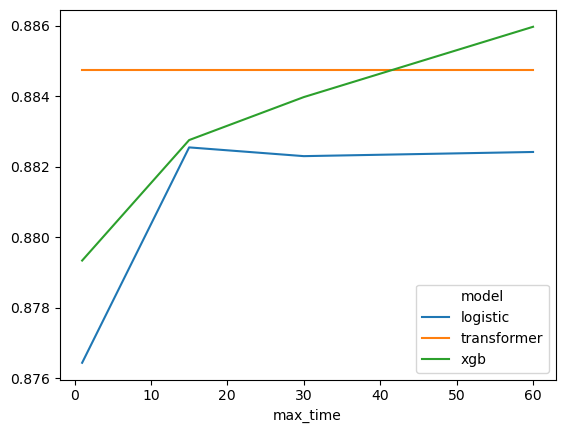

In [38]:
aggregate_results['mean'].plot()

In [39]:
aggregate_results_mine = pd.pivot_table(results_test_set_mine_across_splits, values="roc", columns="model", index="max_time", aggfunc=['mean', 'std'])
aggregate_results_mine

mean                                        std             \
model    distill_tabpfn mother_net transformer_mine distill_tabpfn mother_net   
max_time                                                                        
1              0.814102   0.865402         0.886912       0.175888   0.134813   

                           
model    transformer_mine  
max_time                   
1                0.130563

<Axes: xlabel='max_time', ylabel='roc'>

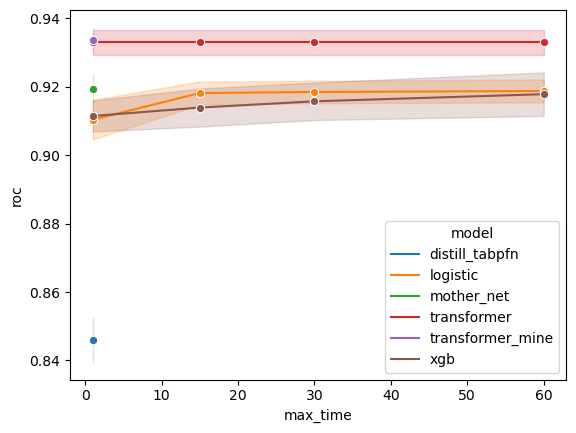

In [128]:
import seaborn as sns
sns.lineplot(weird_reshape, x="max_time", y="roc", hue="model", errorbar="sd", marker="o")